In [1]:
from mxnet import nd
from mxnet.gluon.model_zoo import vision
import pandas as pd
import mxnet as mx
import skimage.io
import skimage.transform
from mxnet import image
import os
import numpy as np

C:\Users\v-dinliu\AppData\Local\Continuum\anaconda3\envs\mxnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
cd ..

Z:\v-dinliu\Flow2D


In [4]:
%%time
with open('visualization/imagenet_class.txt', 'r') as fi:
    buf = fi.read()
    class_name = eval(buf)
import sys
sys.path.append('//msralab/projectdata/ehealth02/v-dinliu/Flow2D')
from reader.chairs import binary_reader, trainval
trainSet, validationSet = trainval.read('//msralab/ProjectData/ehealth02/v-dinliu/Flow2D/Data/FlyingChairs_release/FlyingChairs_train_val.txt')
validationSize = len(validationSet)
validationImg1, validationImg2, validationFlow = binary_reader.load(r"\\msralab\ProjectData\ScratchSSD\Users\v-dinliu\data\FlyingChairsBlock", "val")

Wall time: 18 s


In [19]:
nd.expand_dims?

In [30]:
def call_mx_func(func, *args):
    nd_args = []
    for arg in args:
        arg = nd.array(arg)
        if arg.ndim == 3:
            arg = nd.expand_dims(arg, 0)
        if arg.shape[3] <= 3:
            arg = nd.transpose(arg, (0, 3, 1, 2))
        arg = nd_args.append(arg)
    nd_ret = func(*nd_args)
    if not isinstance(nd_ret, nd.NDArray):
        nd_ret = nd_ret[0]
    ret = nd.transpose(nd_ret, (0, 2, 3, 1)).asnumpy()
    if ret.shape[0] == 1:
        ret = ret[0]
    return ret

def preprocessing(img, scale=(224, 224)):
    if scale is not None:
        img = skimage.transform.resize(img, scale)
    img = nd.array(img)
    img = nd.broadcast_minus(img, nd.array([[[0.485, 0.456, 0.406]]]))
    img = nd.broadcast_div(img, nd.array([[[0.229, 0.224, 0.225]]]))
    return nd.transpose(img, (2, 0, 1))

In [3]:
model = vision.resnet50_v1(pretrained=True)
model.hybridize()

In [4]:
img = skimage.io.imread('C:/Users/v-dinliu/Pictures/dog1.jpg')

In [49]:
def preprocessing(img, scale=(224, 224)):
    if scale is not None:
        img = skimage.transform.resize(img, scale)
    img = nd.array(img)
    img = nd.broadcast_minus(img, nd.array([[[0.485, 0.456, 0.406]]]))
    img = nd.broadcast_div(img, nd.array([[[0.229, 0.224, 0.225]]]))
    return nd.transpose(img, (2, 0, 1))

In [50]:
img = validationImg1[300]

In [69]:
model.features

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=64)
  (2): Activation(relu)
  (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (4): HybridSequential(
    (0): BottleneckV1(
      (body): HybridSequential(
        (0): Conv2D(64 -> 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=64)
        (2): Activation(relu)
        (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=64)
        (5): Activation(relu)
        (6): Conv2D(64 -> 256, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=256)
      )
      (downsample): HybridSequential(
        (0): Conv2D(64 -> 256, ke

In [63]:
from network.hybridnet import get_features
fmap, = get_features(model.features, nd.expand_dims(preprocessing(img, scale=None), 0), [8])
fmap = fmap.asnumpy()

(array([1.608e+03, 2.800e+02, 9.900e+01, 3.400e+01, 1.600e+01, 7.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([   0.        ,  329.67275391,  659.34550781,  989.01826172,
        1318.69101563, 1648.36376953, 1978.03652344, 2307.70927734,
        2637.38203125, 2967.05478516, 3296.72753906]),
 <a list of 10 Patch objects>)

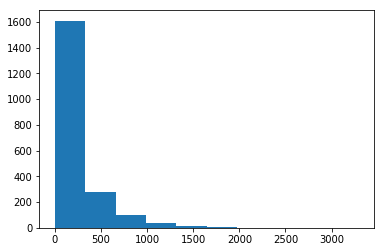

In [67]:
plt.hist(fmap.flatten())

In [59]:
fmap.shape

(1, 2048, 12, 16)

In [48]:
for r, cid in enumerate(np.argsort(-pred[0])):
    if r >= 5: 
        break
    print(class_name[cid])

file, file cabinet, filing cabinet
birdhouse
prison, prison house
coil, spiral, volute, whorl, helix
mailbox, letter box


In [5]:
from network import get_pipeline

In [8]:
pipe = get_pipeline('hybridnet-coarse', ctx=mx.cpu(), lr_mult=1)

In [31]:
ts = (320, 448)
fmap = call_mx_func(pipe.network, preprocessing(validationImg1[10], ts), preprocessing(validationImg2[10], ts))

C:\Users\v-dinliu\AppData\Local\Continuum\anaconda3\envs\mxnet\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [33]:
fmap.shape

(10, 14, 2)

In [43]:
pipe.network.flow[0].weight.lr_mult = 0.02

In [45]:
pipe.trainer._optimizer